# Automatic classification of behaviours

based on vector field analysis

Previous model definition and simulation steps are organized in this single script.
The script does not bother to adopt OO because the whole purpose is to modulate the code and to improve code reuse.
We may or may not want to organize the code into OO (probably not. We do want to 
constrain and check the input to the function at some point, but keeping it non-OO
seems a more natural way as long as the documentation is there).

In [1]:
include("simu_utils.jl")

simu_sde

## Get the vector field

In this first implementation of vector field, we also return the grid since there is no `linspace()`, which is not very julia-ish. However, the mechanism is basically the same.
In later versions, we also return the magnitude and the density of the trajectory, i.e., the number of passage on the grid.

In [2]:
"""
Smoothed average vector field
"""
function vector_field(sol, stress_t, dt; smooth_size = 5)
    t_vec, σ_vec, A_vec = interpret_sol(sol)
    dσdt = zeros((maximum(σ_vec) + 1, maximum(A_vec) + 1))
    dAdt = zeros((maximum(σ_vec) + 1, maximum(A_vec) + 1))
    passage = zeros((maximum(σ_vec) + 1, maximum(A_vec) + 1))
    
    for i = 1:(length(t_vec) - 1)
        if t_vec[i] >= stress_t
            dσ = σ_vec[i + 1] - σ_vec[i]
            dA = A_vec[i + 1] - A_vec[i]
            dσdt[σ_vec[i] + 1, A_vec[i] + 1] += dσ/dt
            dAdt[σ_vec[i] + 1, A_vec[i] + 1] += dA/dt
            passage[σ_vec[i] + 1, A_vec[i] + 1] += 1
        end
    end
    
    # avoid divide 0 error
    for i = 1:size(passage)[1]
        for j = 1:size(passage)[2]
            if passage[i, j] == 0
                passage[i, j] = 1
            end
        end
    end
    
    # normalize
    dσdt ./= passage
    dAdt ./= passage
    
    # smooth vector field
    σ_size = Int64(ceil(size(dσdt)[1] / smooth_size))
    A_size = Int64(ceil(size(dσdt)[2] / smooth_size))
    dσdt_smooth = zeros(σ_size, A_size)
    dAdt_smooth = zeros(σ_size, A_size)
    σ_vec = zeros(σ_size)
    A_vec = zeros(A_size)
    for i = 1:σ_size
        for j = 1:A_size
            σ_start_idx = (i - 1) * smooth_size + 1
            σ_end_idx = min(i * smooth_size, size(dσdt)[1])
            A_start_idx = (j - 1) * smooth_size + 1
            A_end_idx = min(j * smooth_size, size(dσdt)[2])
            dσdt_smooth[i, j] = mean(dσdt[σ_start_idx:σ_end_idx, A_start_idx:A_end_idx])
            dAdt_smooth[i, j] = mean(dAdt[σ_start_idx:σ_end_idx, A_start_idx:A_end_idx])
            σ_vec[i] = 0.5 * (σ_start_idx + σ_end_idx)    # redunt calculation but not big deal
            A_vec[j] = 0.5 * (A_start_idx + A_end_idx)
        end
    end
    # generate meshgrid
    σ_grid = σ_vec * ones(A_size)'
    A_grid = ones(σ_size) * A_vec'
    
    return(σ_grid, A_grid, dσdt_smooth, dAdt_smooth)
end

"""
plot the vector field
"""
function plot_vf(σ, A, dσdt, dAdt; scale = 1.0, threshold = 1e-4)
    # hide small vectors
    for i = 1:size(σ)[1]
        for j = 1:size(σ)[2]
            if scale * sqrt(dσdt[i, j]^2 + dAdt[i, j]^2) < threshold
                dσdt[i, j] = 0.0
                dAdt[i, j] = 0.0
            end
        end
    end
    quiver(σ[:], A[:], quiver = (scale .* dσdt[:], scale .* dAdt[:]), alpha = 0.5, color = "blue")
end
function plot_vf!(plt, σ, A, dσdt, dAdt; scale = 1.0, threshold = 1e-4)
    # hide small vectors
    for i = 1:size(σ)[1]
        for j = 1:size(σ)[2]
            if scale * sqrt(dσdt[i, j]^2 + dAdt[i, j]^2) < threshold
                dσdt[i, j] = 0.0
                dAdt[i, j] = 0.0
            end
        end
    end
    quiver!(plt, σ[:], A[:], quiver = (scale .* dσdt[:], scale .* dAdt[:]), alpha = 0.5, color = "blue")
end

plot_vf! (generic function with 1 method)

In [3]:
"""
superimpose the density to vector field
"""
function plot_vf_and_density(σ_grid, A_grid, dσdt, dAdt, sol, stress_t, smooth_size; 
        v_threshold = 1e-2, d_threshold = 1e-2, scale = 1.0)
    t_vec, σ_vec, A_vec = interpret_sol(sol)
    
    # count the number of molecules
    n_passage = zeros(maximum(σ_vec) + 1, maximum(A_vec) + 1)
    for i in 1:length(t_vec)
        if t_vec[i] >= stress_t
            n_passage[σ_vec[i] + 1, A_vec[i] + 1] += 1
        end
    end
    
    # smooth the density
    σ_size = Int64(ceil(size(n_passage)[1] / smooth_size))
    A_size = Int64(ceil(size(n_passage)[2] / smooth_size))
    if (σ_size != size(σ_grid)[1]) || (A_size != size(σ_grid)[2])
        println("Warning: the size of the vector field does not agree with density. Please check")
    end
    n_passage_smooth = zeros(σ_size, A_size)    # initialize
    for i = 1:σ_size
        for j = 1:A_size
            σ_start_idx = (i - 1) * smooth_size + 1
            σ_end_idx = min(i * smooth_size, size(n_passage)[1])
            A_start_idx = (j - 1) * smooth_size + 1
            A_end_idx = min(j * smooth_size, size(n_passage)[2])
            n_passage_smooth[i, j] = mean(n_passage[σ_start_idx:σ_end_idx, A_start_idx:A_end_idx])
        end
    end
    
    # normalize
    n_passage_log = log.(n_passage_smooth .+ 1)
    n_passage_log ./= maximum(n_passage_log)
    
    # fixed points detection
    max_vector = maximum(sqrt.(dσdt.^2 + dAdt.^2))
    ϵ = 1e-2
    n_fp = 0
    σ_fp = zeros(length(σ_grid[:]))
    A_fp = zeros(length(σ_grid[:]))
    n_log_fp = zeros(length(σ_grid[:]))
    for i = 1:σ_size
        for j = 1:A_size
            if n_passage_smooth[i, j] > maximum(n_passage_smooth) * ϵ &&
                sqrt(dσdt[i, j]^2 + dAdt[i, j]^2) < max_vector * ϵ
                # exists on the trajectory, but gradient is zero
                n_fp += 1
                σ_fp[n_fp] = σ_grid[i, 1]
                A_fp[n_fp] = A_grid[1, j]
                n_log_fp[n_fp] = n_passage_log[i, j]
            end
        end
    end
    σ_fp = σ_fp[1:n_fp]
    A_fp = A_fp[1:n_fp]
    n_log_fp = n_log_fp[1:n_fp]
    
    # another fp detection algo
    vec_len = sqrt.(dσdt.^2 .+ dAdt.^2)
    v_min_x, v_min_y = mat_local_min(vec_len)
    d_max_x, d_max_y = mat_local_min(-n_passage_smooth)
    # get the intersect
    is_v_min = fill(false, size(dσdt))
    for i = 1:length(v_min_x)
        is_v_min[v_min_x[i], v_min_y[i]] = true
    end
    is_d_max = fill(false, size(dσdt))
    for i = 1:length(d_max_x)
        is_d_max[d_max_x[i], d_max_y[i]] = true
    end
    is_fp = is_v_min .& is_d_max .& (n_passage_smooth .> 0)
    fp_x = σ_grid[is_fp]
    fp_y = A_grid[is_fp]
    
    # plot vector field
    #TODO! d_threshold is not implemented
    plt = plot(σ_grid[:], A_grid[:], seriestype = :scatter, markerstrokewidth = 0,
        color = "black", legend = false, alpha = n_passage_log[:], markersize = 5)
#     plot!(plt, σ_fp, A_fp, alpha = n_log_fp, color = "red", 
#         seriestype = :scatter, markerstrokewidth = 0, markersize = 10)
    plot!(plt, fp_x, fp_y, color = "green", 
        seriestype = :scatter, markerstrokewidth = 0, markersize = 10)
    plot_vf!(plt, σ_grid, A_grid, dσdt, dAdt, threshold = v_threshold)
end

plot_vf_and_density

In [4]:
function mat_local_min(mat)
    n_min = 0
    x_idx = zeros(Int64, length(mat[:]))
    y_idx = zeros(Int64, length(mat[:]))
    for i = 1:size(mat)[1]
        for j = 1:size(mat)[2]
            x_start = max(1, i - 1)
            x_end = min(size(mat)[1], i + 1)
            y_start = max(1, j - 1)
            y_end = min(size(mat)[2], j + 1)
            if(minimum(mat[x_start:x_end, y_start:y_end]) == mat[i, j])
                n_min += 1
                x_idx[n_min] = i
                y_idx[n_min] = j
            end
        end
    end
    x_idx = x_idx[1:n_min]    # truncate
    y_idx = y_idx[1:n_min]
    return x_idx, y_idx
end

mat_local_min (generic function with 1 method)

Use the pyplot backend. GR() turned out to be a better choice

In [5]:
pyplot()    # switch plot backend

Plots.PyPlotBackend()

## Crucial behaviours

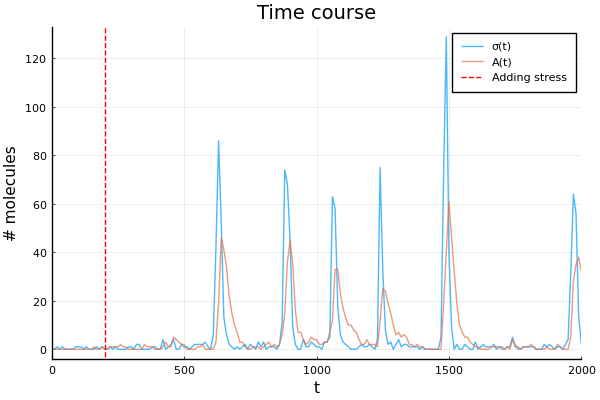

KD/KS = 0.5; KS = 15.0; τ₂/τ₁ = 5.0; β= 100.0; n = 3.0

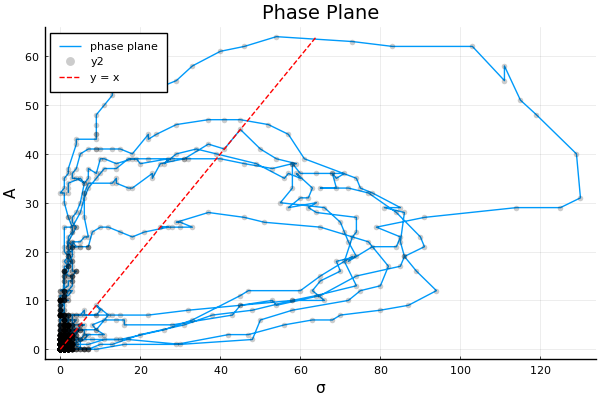

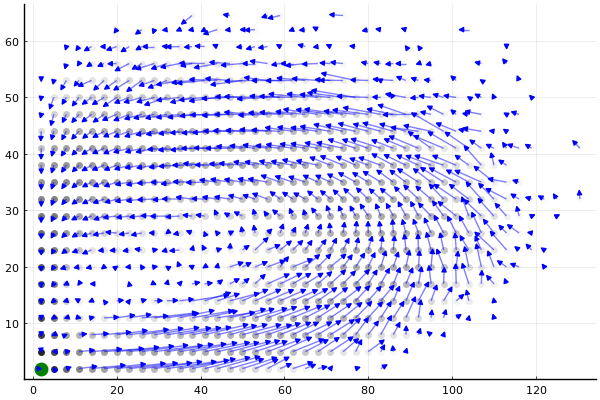


KD/KS = 1.0; KS = 0.5; τ₂/τ₁ = 5.0; β= 100.0; n = 3.0


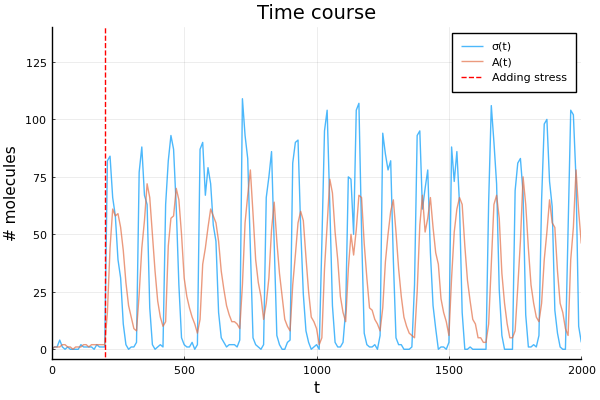

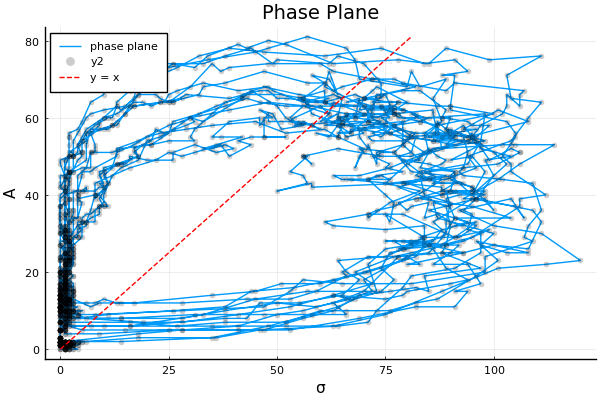

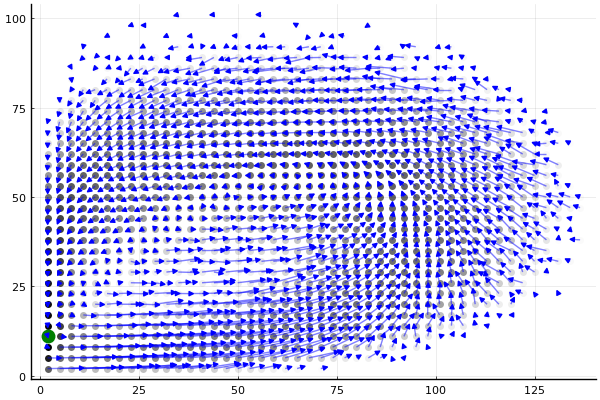

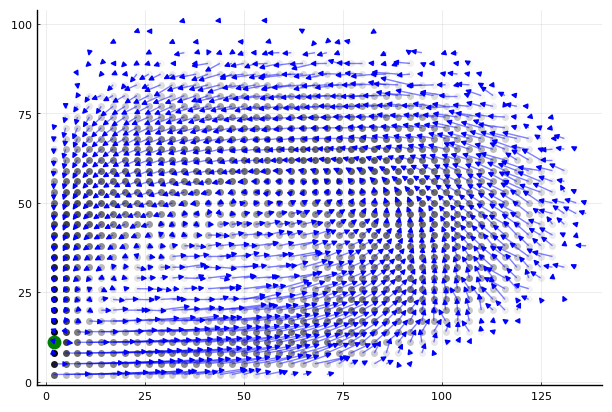

In [81]:
# though the new algo is more robust
# it is highly reliable to the smooth size
timescale = 5
timecourse = 1e6
smooth_size = 3

sigma_model = reaction_system()

# stochastic pulsing
sol_sp = simu_all(sigma_model, _KS = 15.0, _rK = 0.5, _β = 100.0, _τ₁ = timescale, _rτ = 5.0, _n = 3.0, 
    show_hill = false, max_t = timecourse)

σ, A, dσdt_sp, dAdt_sp = vector_field(sol_sp, 200.0, 1.0, smooth_size = smooth_size);

display(plot_vf_and_density(σ, A, dσdt_sp, dAdt_sp, sol_sp, 200.0, smooth_size, scale = timescale * 2.0))

# oscillation
sol_os = simu_all(sigma_model, _KS = 0.5, _rK = 1.0, _β = 100.0, _τ₁ = timescale, _rτ = 5.0, _n = 3.0, 
    show_hill = false, max_t = timecourse)

σ, A, dσdt_os, dAdt_os = vector_field(sol_os, 200.0, 1.0, smooth_size = smooth_size);

display(plot_vf_and_density(σ, A, dσdt_os, dAdt_os, sol_os, 200.0, smooth_size, scale = timescale * 0.5))

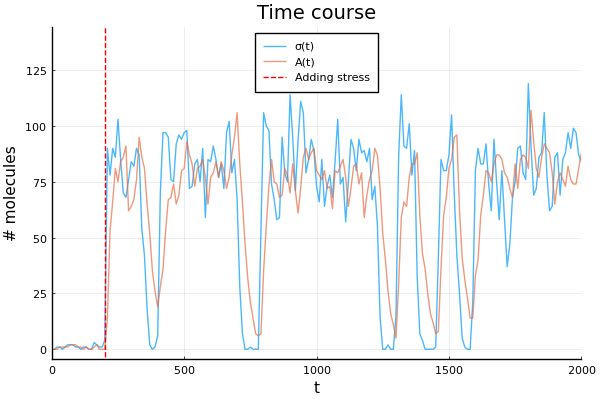

KD/KS = 1.6; KS = 1.0; τ₂/τ₁ = 5.0; β= 100.0; n = 3.0

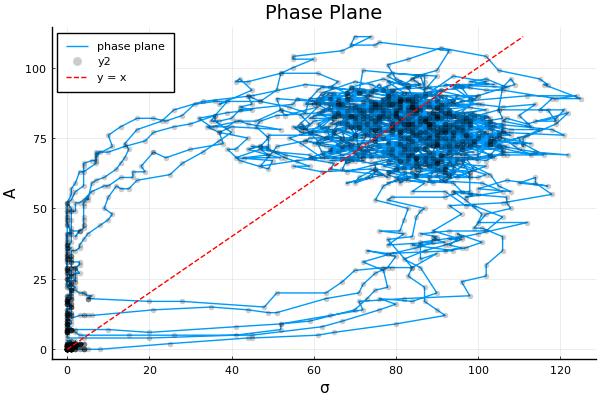

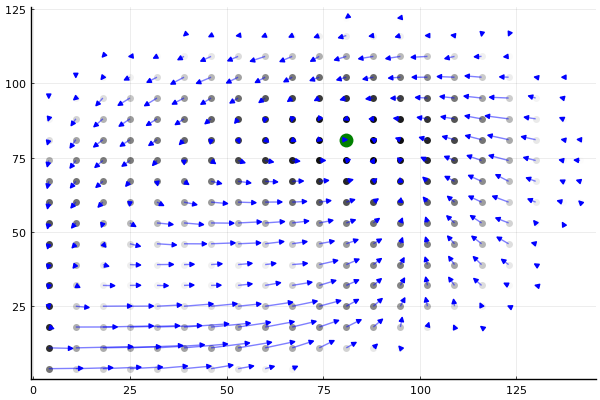


KD/KS = 1.6; KS = 15.0; τ₂/τ₁ = 5.0; β= 100.0; n = 3.0

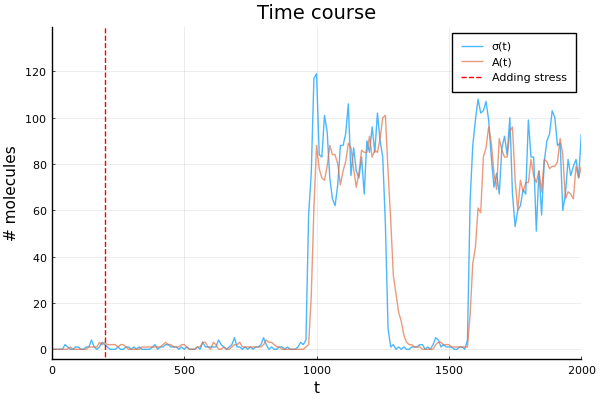

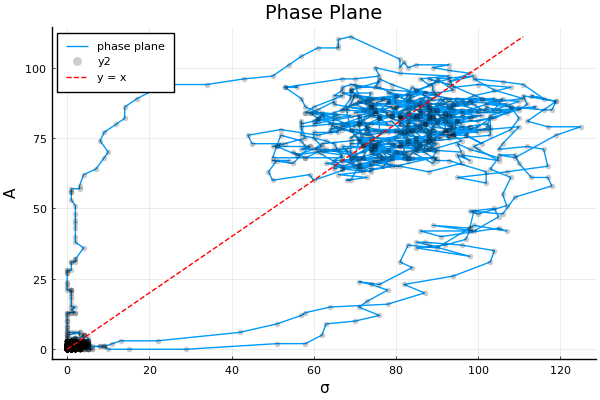

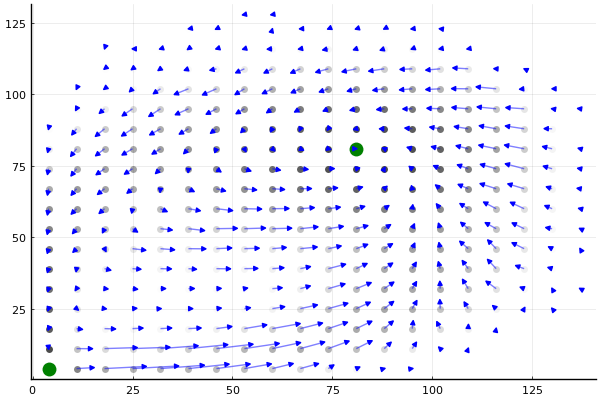

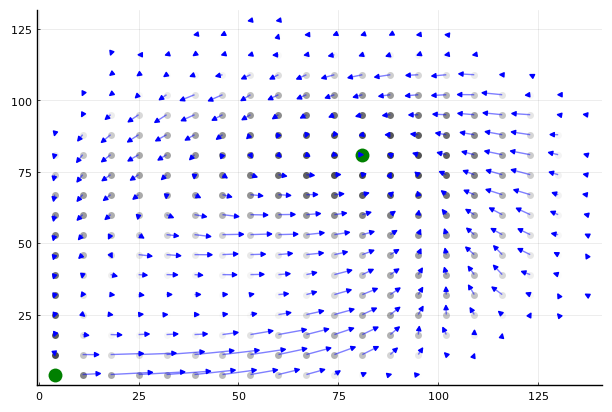

In [176]:
smooth_size = 7

# stochastic anti-pulsing
sol_ap = simu_all(sigma_model, _KS = 1.0, _rK = 1.6, _β = 100.0, _τ₁ = timescale, _rτ = 5.0, _n = 3.0, 
    show_hill = false, max_t = timecourse)

σ, A, dσdt_ap, dAdt_ap = vector_field(sol_ap, 200.0, 1.0, smooth_size = smooth_size);

display(plot_vf_and_density(σ, A, dσdt_ap, dAdt_ap, sol_ap, 200.0, smooth_size, scale = timescale * 2.0))

# stochastic switching
sol_ap = simu_all(sigma_model, _KS = 15.0, _rK = 1.6, _β = 100.0, _τ₁ = timescale, _rτ = 5.0, _n = 3.0, 
    show_hill = false, max_t = timecourse)

σ, A, dσdt_ap, dAdt_ap = vector_field(sol_ap, 200.0, 1.0, smooth_size = smooth_size);

display(plot_vf_and_density(σ, A, dσdt_ap, dAdt_ap, sol_ap, 200.0, smooth_size, scale = timescale * 2.0))

## Experiment with kernel density

With long simulation time, the kernel density profile cannot be distinguished from the smoothed passage matrix.
If, with the kernel density module, we can estimate the center, then it would be better than identifiying the
maxima on the smoothed passage matrix.

However, we are happy to keep the classifier in this way now, and maybe add kernel density later when
a bottleneck is hit

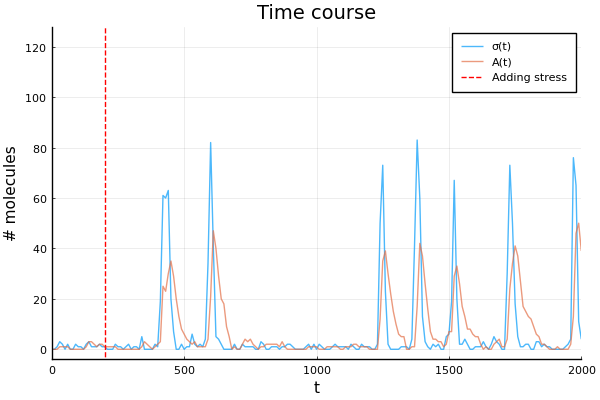

KD/KS = 0.5; KS = 15.0; τ₂/τ₁ = 5.0; β= 100.0; n = 3.0

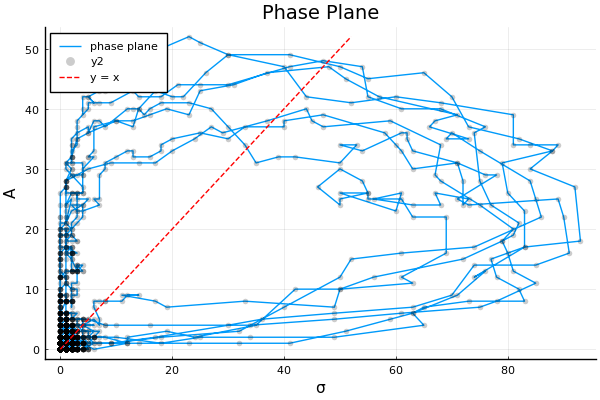

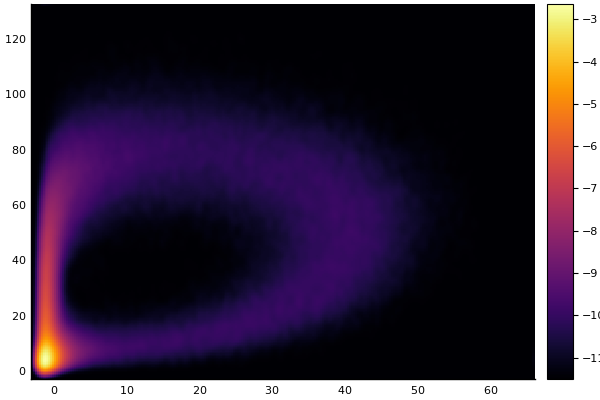

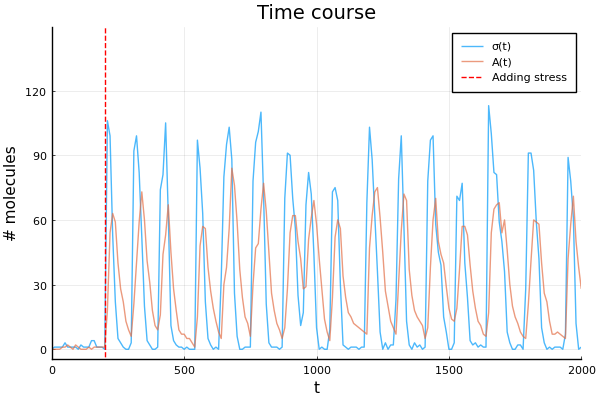


KD/KS = 1.0; KS = 0.5; τ₂/τ₁ = 5.0; β= 100.0; n = 3.0


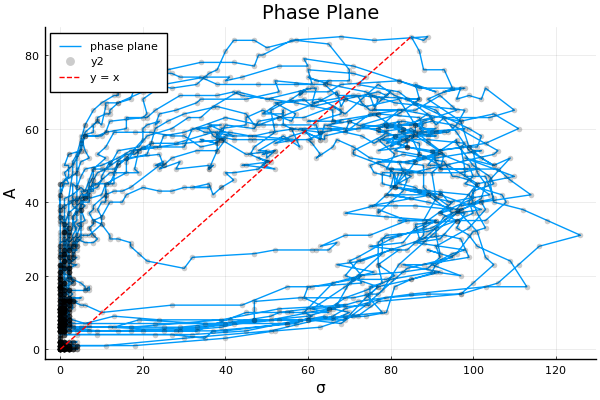

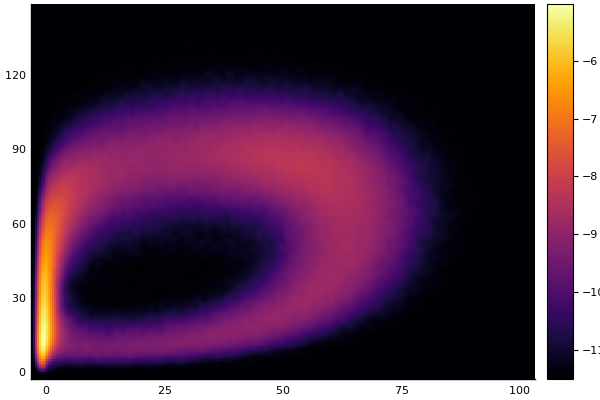

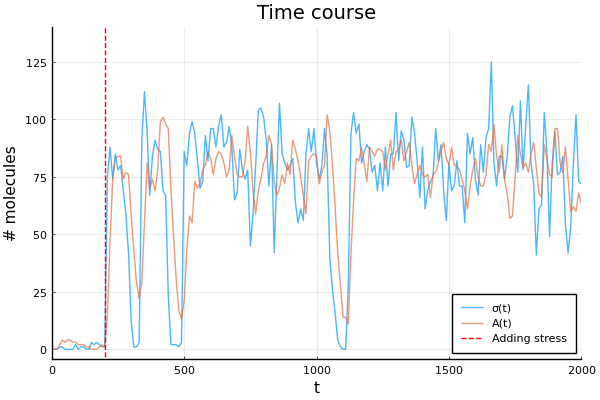


KD/KS = 1.6; KS = 1.0; τ₂/τ₁ = 5.0; β= 100.0; n = 3.0


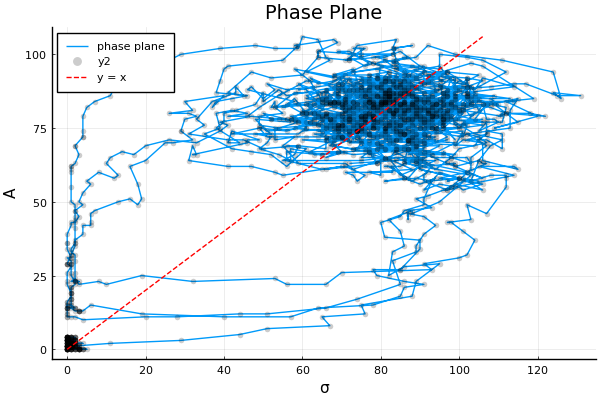

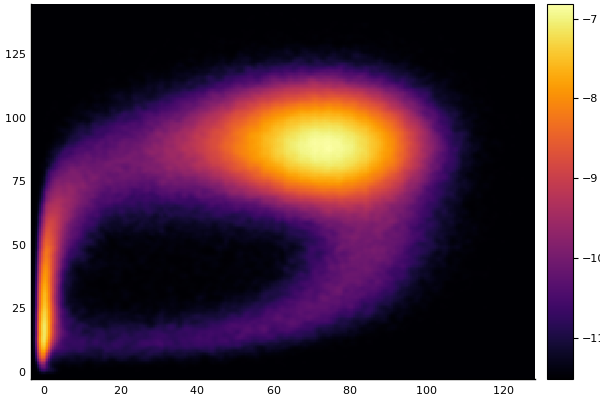

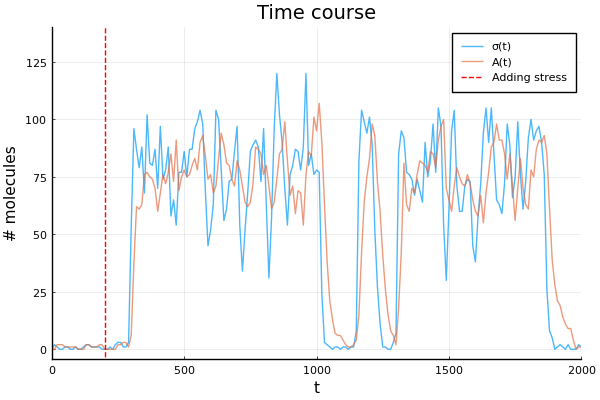


KD/KS = 1.6; KS = 15.0; τ₂/τ₁ = 5.0; β= 100.0; n = 3.0


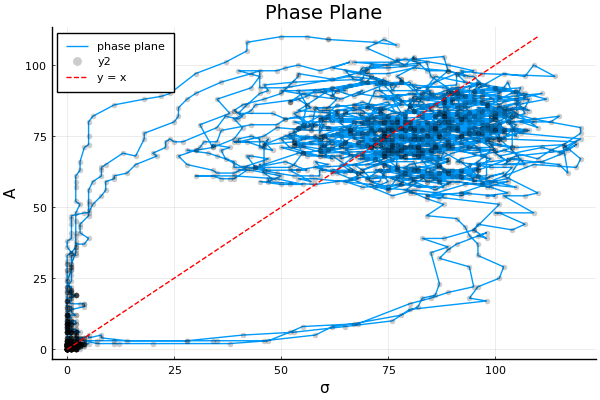

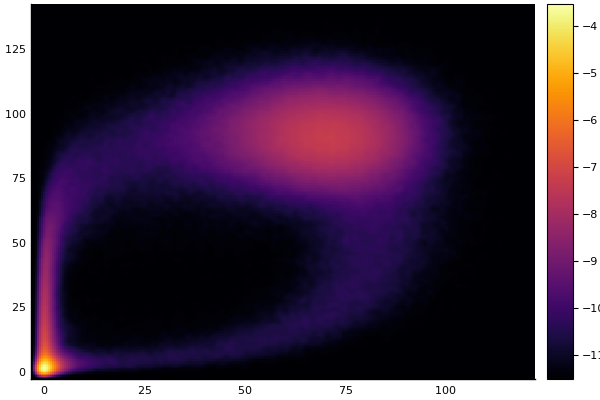

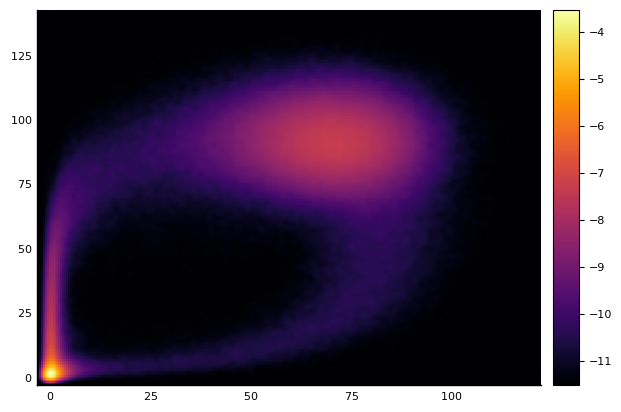

In [82]:
using StatsKit

# stochastic pulsing
sol = simu_all(sigma_model, _KS = 15.0, _rK = 0.5, _β = 100.0, _τ₁ = timescale, _rτ = 5.0, _n = 3.0, 
    show_hill = false, max_t = timecourse)
~, σ, A = interpret_sol(sol)
B = kde((σ, A), bandwidth = (0.75, 0.75))
display(heatmap(B.y, B.x, log.(B.density' .+ 1e-5)))

# oscillation
sol = simu_all(sigma_model, _KS = 0.5, _rK = 1.0, _β = 100.0, _τ₁ = timescale, _rτ = 5.0, _n = 3.0, 
    show_hill = false, max_t = timecourse)
~, σ, A = interpret_sol(sol)
B = kde((σ, A), bandwidth = (0.75, 0.75))
display(heatmap(B.y, B.x, log.(B.density' .+ 1e-5)))

# stochastic anti-pulsing
sol = simu_all(sigma_model, _KS = 1.0, _rK = 1.6, _β = 100.0, _τ₁ = timescale, _rτ = 5.0, _n = 3.0, 
    show_hill = false, max_t = timecourse)
~, σ, A = interpret_sol(sol)
B = kde((σ, A), bandwidth = (0.75, 0.75))
display(heatmap(B.y, B.x, log.(B.density' .+ 1e-5)))

# stochastic switching
sol = simu_all(sigma_model, _KS = 15.0, _rK = 1.6, _β = 100.0, _τ₁ = timescale, _rτ = 5.0, _n = 3.0, 
    show_hill = false, max_t = timecourse)
~, σ, A = interpret_sol(sol)
B = kde((σ, A), bandwidth = (0.75, 0.75))
display(heatmap(B.y, B.x, log.(B.density' .+ 1e-5)))